# Shopper Spectrum Clustering and Recommendation

## Github

https://github.com/aniket010011/Intern-Projects

## Problem Description

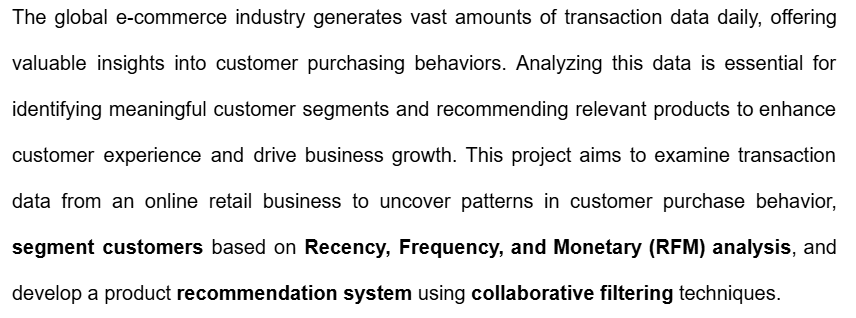

## Objectives

*   Segmentation of different customers types for marketing target audiences
*   Personalizing product recommendations for Ecommerce platforms
*   Identifying High Risk customers to assist with retention
*   Managing Inventory and stock as per customer demand





## Solution

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, fbeta_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

Dataset Loading and Inspection

In [2]:
file_data = '/content/online_retail.csv'
df_data = pd.read_csv(file_data)

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df_data.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


### Processing Data

Removing Missing CustomerID

In [7]:
df_data = df_data.dropna(subset=["CustomerID"])

Removing Cancelled Orders

In [8]:
df_data = df_data[~df_data["InvoiceNo"].astype(str).str.startswith("C")]

Removing invalid Quantity and Pricing information

In [9]:
df_data = df_data[(df_data["Quantity"] > 0) & (df_data["UnitPrice"] > 0)]

Converting date to datetime format

In [10]:
df_data["InvoiceDate"] = pd.to_datetime(df_data["InvoiceDate"])

In [11]:
df_data.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


### RFM Analysis and Feature Engineering

Create Total Price

In [12]:
df_data["TotalPrice"] = df_data["Quantity"] * df_data["UnitPrice"]

Define Reference Date

In [13]:
reference_date = df_data["InvoiceDate"].max() + pd.Timedelta(days=1)

Compute RFM Table

In [14]:
rfm = df_data.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


RFM Distributions

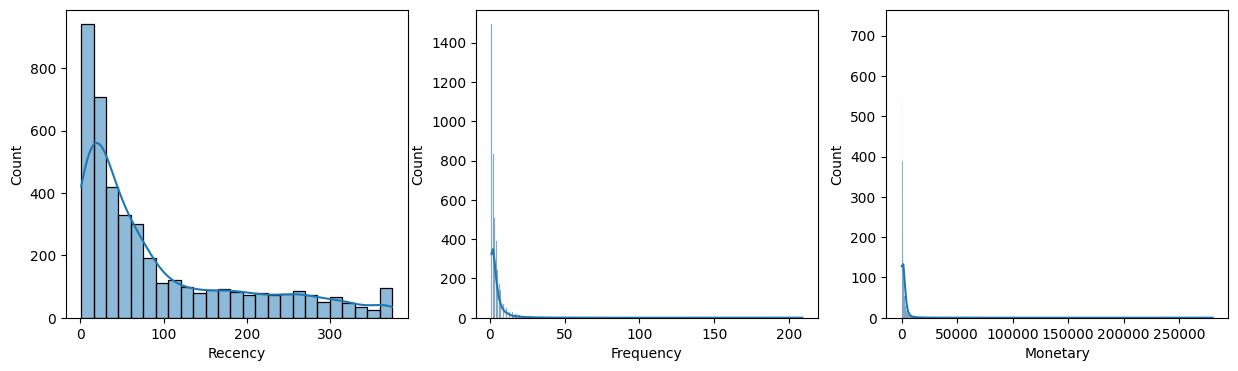

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(rfm["Recency"], ax=axes[0], kde=True)
sns.histplot(rfm["Frequency"], ax=axes[1], kde=True)
sns.histplot(rfm["Monetary"], ax=axes[2], kde=True)

plt.show()

The above 3 charts show the distribution for Recency, Frequency and Monetary charateristics of customer transactions respectively.

### Exploratory Data Analysis

Transactions by Country

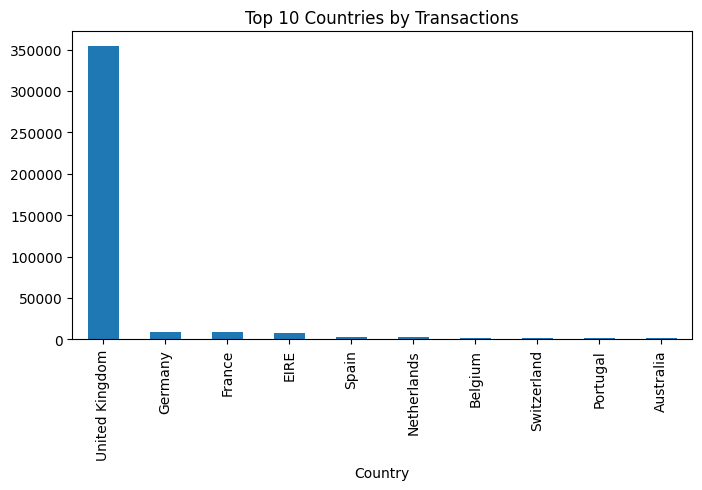

In [16]:
df_data["Country"].value_counts().head(10)

plt.figure(figsize=(8,4))
df_data["Country"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Countries by Transactions")
plt.show()

This chart shows the country based purchasing count by customers. We can find that maximum number of purchases are made from the country UK.

Unique Customers by Country

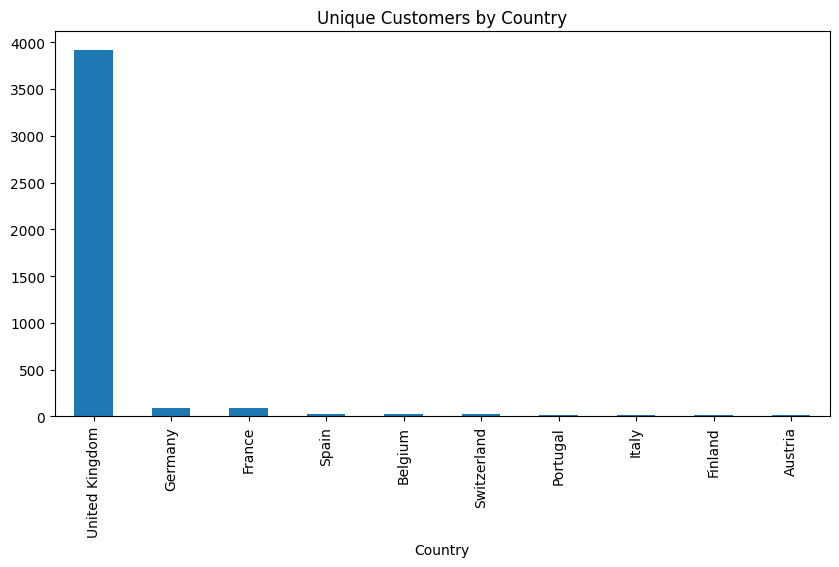

In [17]:
plt.figure(figsize=(10,5))
df_data.groupby("Country")["CustomerID"].nunique().sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Unique Customers by Country")
plt.show()


This chart shows the number of unique customers by country. We can see UK has the most number of unique customers.

Top-Selling Products

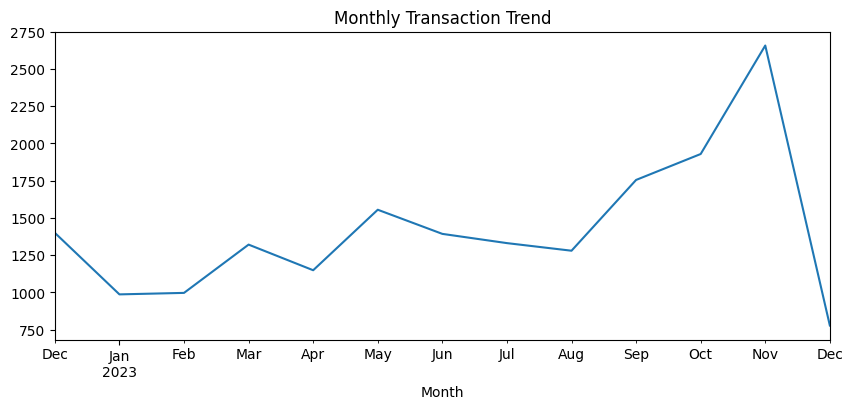

In [18]:
top_products = (
    df_data.groupby("Description")["Quantity"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_products

df_data["Month"] = df_data["InvoiceDate"].dt.to_period("M")

monthly_sales = df_data.groupby("Month")["InvoiceNo"].nunique()

monthly_sales.plot(figsize=(10,4))
plt.title("Monthly Transaction Trend")
plt.show()

This chart shows the transaction trend across all the months throughout the year. We can see the period between January to February, there were least transactions and the highest number of transactions were attained on November.

Top Products by Revenue

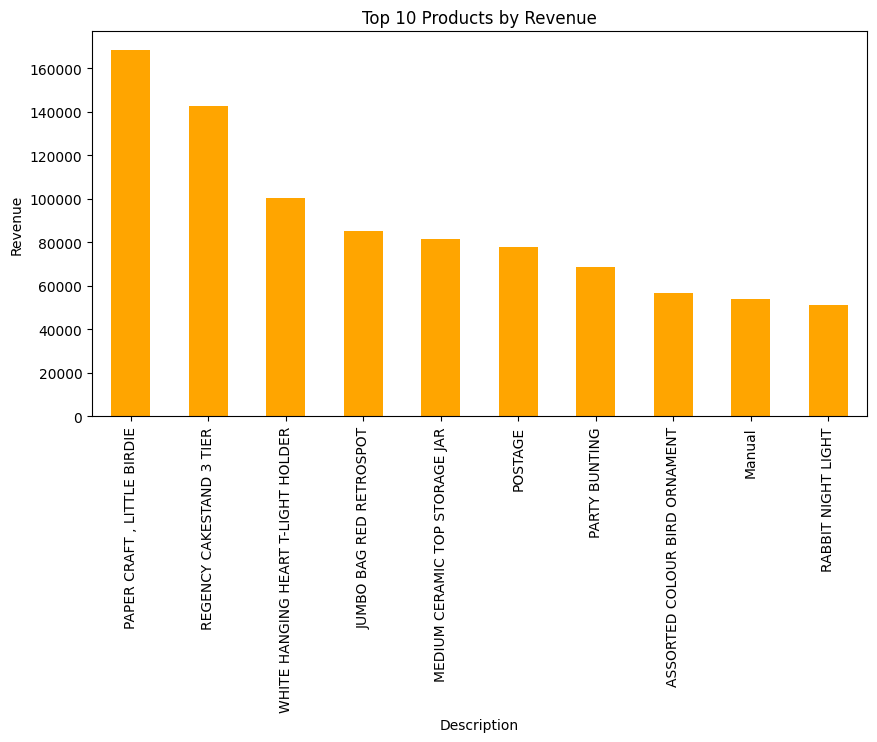

In [19]:
top_products_revenue = df_data.groupby("Description")["TotalPrice"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_products_revenue.plot(kind="bar", color="orange")
plt.title("Top 10 Products by Revenue")
plt.ylabel("Revenue")
plt.show()

This chart shows the top 10 products driving the most revenue for the ecommerce firm. The top revenue generating product is found to be 'Paper Craft, Little Birdie'

Monthly Sales Trend

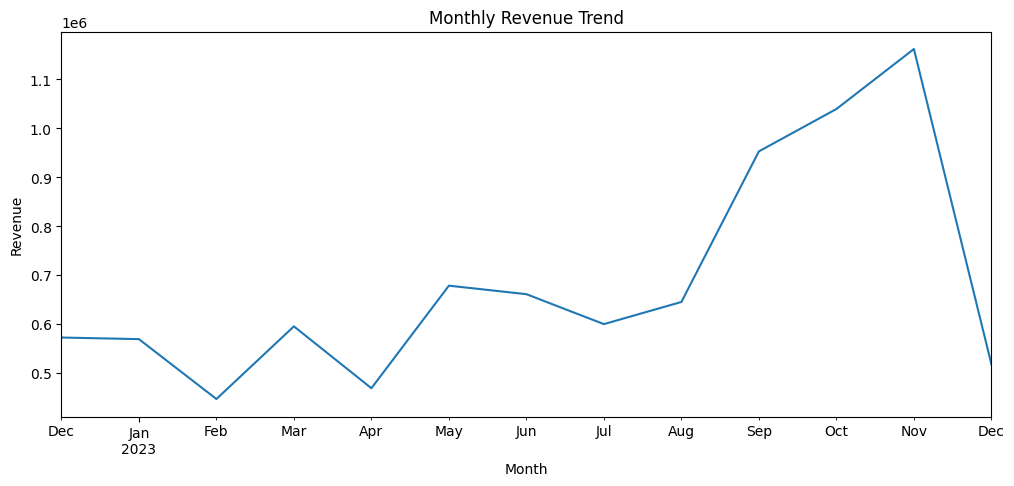

In [20]:
df_data["Month"] = df_data["InvoiceDate"].dt.to_period("M")

monthly_revenue = df_data.groupby("Month")["TotalPrice"].sum()

monthly_revenue.plot(figsize=(12,5))
plt.title("Monthly Revenue Trend")
plt.ylabel("Revenue")
plt.show()

This chart shows the monthly sales trend across all the months. As expected, this chart matches monthly transaction trend we analysed earlier.

Monthly Transactions

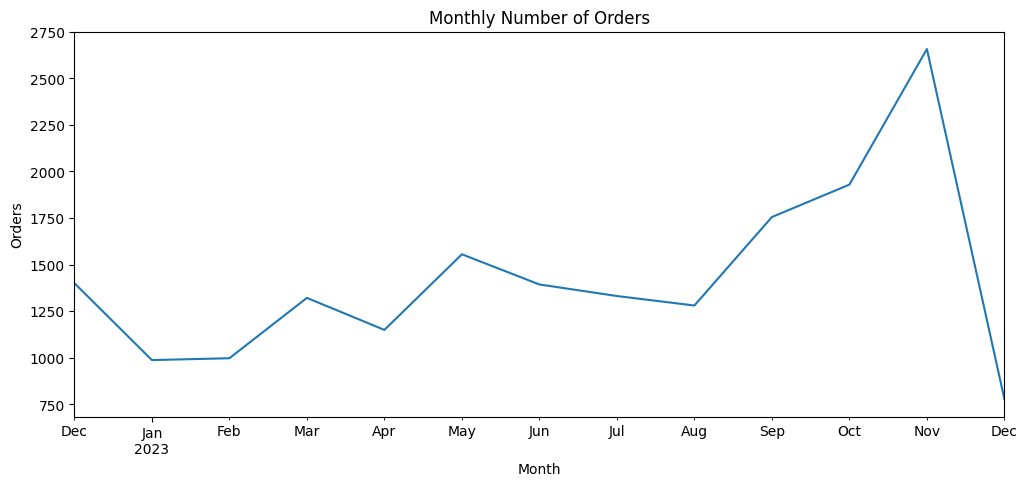

In [21]:
monthly_orders = df_data.groupby("Month")["InvoiceNo"].nunique()

monthly_orders.plot(figsize=(12,5))
plt.title("Monthly Number of Orders")
plt.ylabel("Orders")
plt.show()

This chart shows the monthly orders throughout the year. As expected this chart is in line with the monthly transaction trend and monthly sales chart.

Daily Sales

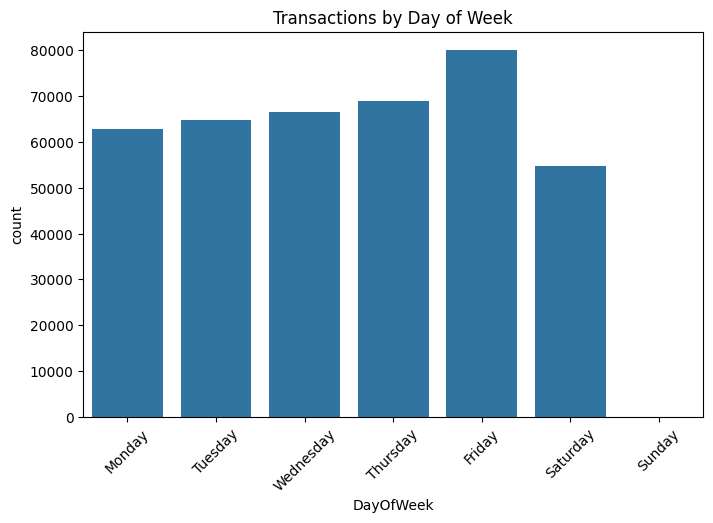

In [22]:
df_data["DayOfWeek"] = df_data["InvoiceDate"].dt.day_name()

plt.figure(figsize=(8,5))
sns.countplot(data=df_data, x="DayOfWeek", order=[
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
])
plt.title("Transactions by Day of Week")
plt.xticks(rotation=45)
plt.show()

This chart shows the daily sales trend over a week. Maximum sales is noticed on Friday and no sales on Sunday which is a holiday.

Hourly Sales

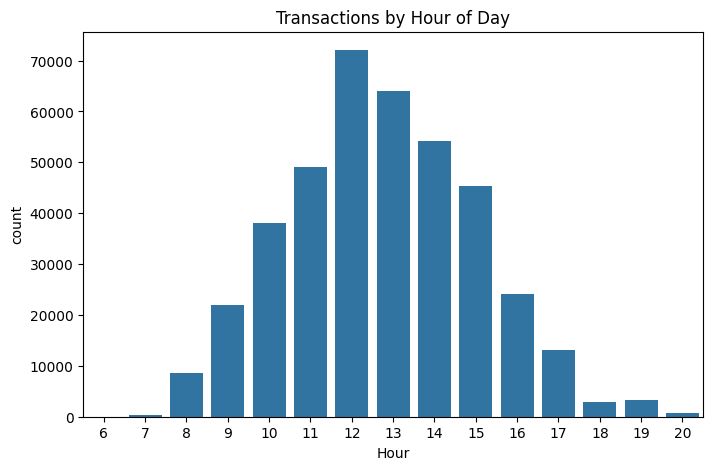

In [23]:
df_data["Hour"] = df_data["InvoiceDate"].dt.hour

plt.figure(figsize=(8,5))
sns.countplot(data=df_data, x="Hour")
plt.title("Transactions by Hour of Day")
plt.show()

This chart shows the hourly sales trend throughout a day. Maximum sales is observed around the mid-day mark and sales are observed to be low during the late night and early morning hours.

Distribution of Transaction Value

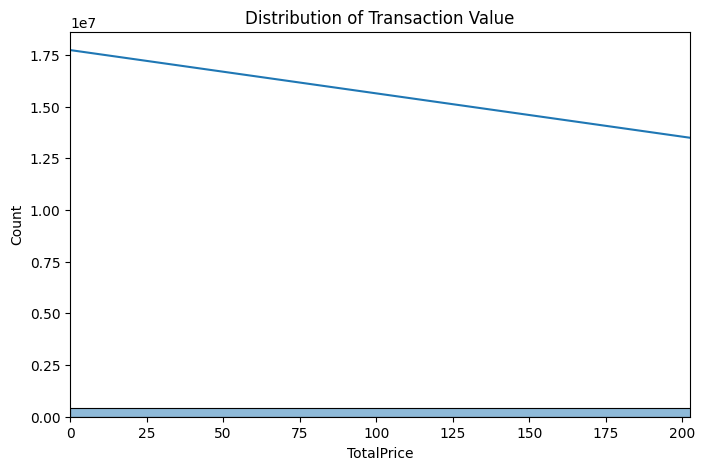

In [24]:
plt.figure(figsize=(8,5))
sns.histplot(df_data["TotalPrice"], bins=50, kde=True)
plt.title("Distribution of Transaction Value")
plt.xlim(0, df_data["TotalPrice"].quantile(0.99))
plt.show()

This chart shows the distribution of transactions based total price. It is clear that less number of high value products are getting purchased and hence the downward slide with increasing total price.

Average Order Value over time

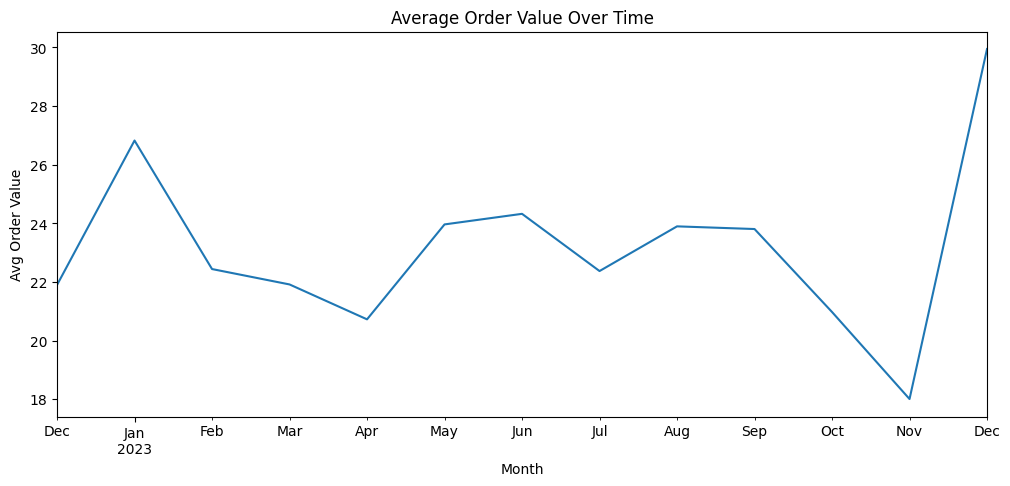

In [25]:
avg_order_value = df_data.groupby("Month")["TotalPrice"].mean()

avg_order_value.plot(figsize=(12,5))
plt.title("Average Order Value Over Time")
plt.ylabel("Avg Order Value")
plt.show()

This chart shows the trend of average order value of items purchased by customers throughout the year. This chart is completely opposite to monthly transaction trend. This suggests the ecommerce has a constant strong base of customers who are purchasing high value products even when transaction trend is low.

Top Customers by Spending

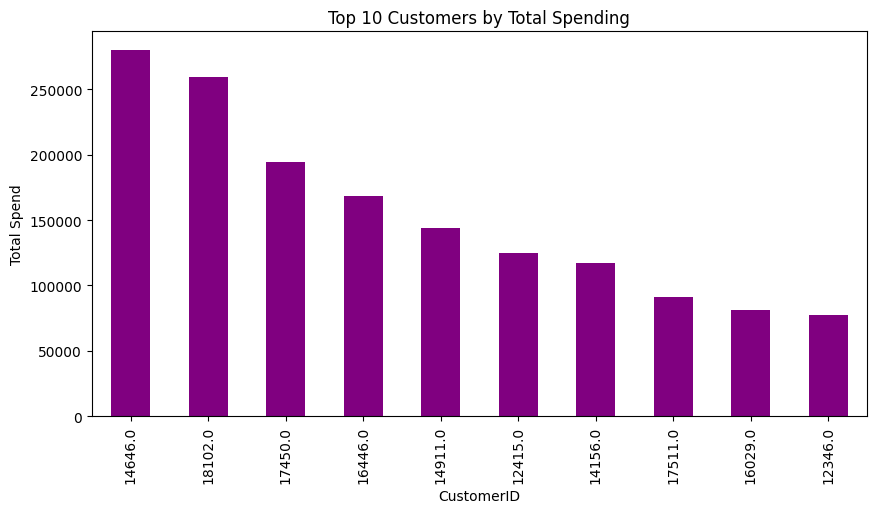

In [26]:
top_customers = df_data.groupby("CustomerID")["TotalPrice"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_customers.plot(kind="bar", color="purple")
plt.title("Top 10 Customers by Total Spending")
plt.ylabel("Total Spend")
plt.show()

This chart shows the top 10 customers based on spending and are mapped in the chart by their Customer ID. This helps the ecommerce firm with targeting customers for retention and remarketing campaigns.

Purchase Frequency per Customer

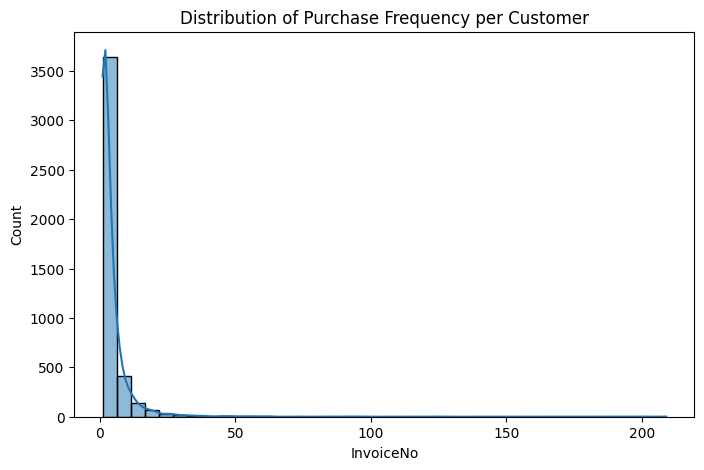

In [27]:
customer_freq = df_data.groupby("CustomerID")["InvoiceNo"].nunique()

plt.figure(figsize=(8,5))
sns.histplot(customer_freq, bins=40, kde=True)
plt.title("Distribution of Purchase Frequency per Customer")
plt.show()

This chart plots the purchase frequency of customers. The number of unique customers is oberved to drop sharply as number of Invoices increases which is expected.

Customer Level Correlation(RFM)

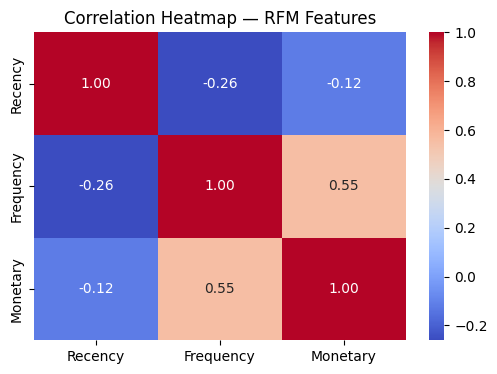

In [28]:
rfm_corr = rfm[["Recency", "Frequency", "Monetary"]].corr()
plt.figure(figsize=(6,4))
sns.heatmap(rfm_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap — RFM Features")
plt.show()

Here a correlation heatmap is made based on the Recency, Frequency and Monetary values of the transactions made by the customers. Monetary shows strong correlation with frequency as more frequently a customer spends, more will be the spending.  

### RFM features and Clustering Pipelines

In [29]:
X_rfm = rfm[["Recency", "Frequency", "Monetary"]]

Kmeans

In [30]:
kmeans_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=4, random_state=42))
])

DBScan

In [31]:
dbscan_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("cluster", DBSCAN(eps=0.8, min_samples=5))
])

Hierarchical/Agglomerative

In [32]:
agglo_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("cluster", AgglomerativeClustering(n_clusters=4))
])

Train & Evaluate Models

In [33]:
pipelines = {
    "KMeans": kmeans_pipeline,
    "DBSCAN": dbscan_pipeline,
    "Agglomerative": agglo_pipeline
}

results = {}

for name, pipe in pipelines.items():
    print(f"Training {name}...")

    labels = pipe.fit_predict(X_rfm)

    unique_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if unique_clusters > 1:
        score = silhouette_score(
            pipe.named_steps["scaler"].transform(X_rfm),
            labels
        )
    else:
        score = -1

    results[name] = {
        "model": pipe,
        "silhouette_score": score,
        "clusters": unique_clusters
    }

Training KMeans...
Training DBSCAN...
Training Agglomerative...


Compare Model Performance

In [34]:
for name, res in results.items():
    print(f"{name} → Silhouette Score: {res['silhouette_score']:.4f}, Clusters: {res['clusters']}")

KMeans → Silhouette Score: 0.6162, Clusters: 4
DBSCAN → Silhouette Score: -1.0000, Clusters: 1
Agglomerative → Silhouette Score: 0.6065, Clusters: 4


Silhouette Score Comparison

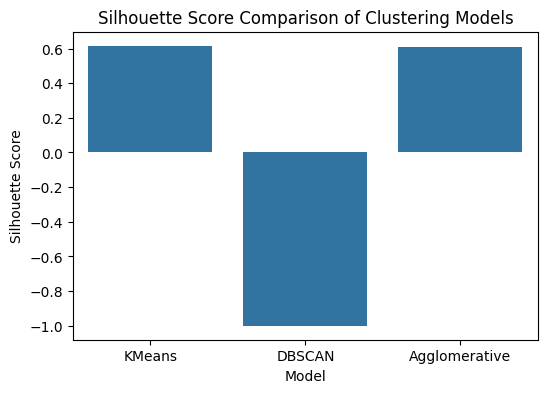

In [35]:
model_names = list(results.keys())
scores = [results[name]["silhouette_score"] for name in model_names]

plt.figure(figsize=(6,4))
sns.barplot(x=model_names, y=scores)
plt.title("Silhouette Score Comparison of Clustering Models")
plt.ylabel("Silhouette Score")
plt.xlabel("Model")
plt.show()

From this plot we can see both K-Means and Hierarchical clustering have positive Silhouette scores. However, DBScan is showing negative silhouette score. So we have to select between K-Means and Hierarchical models.

Number of Clusters by Models

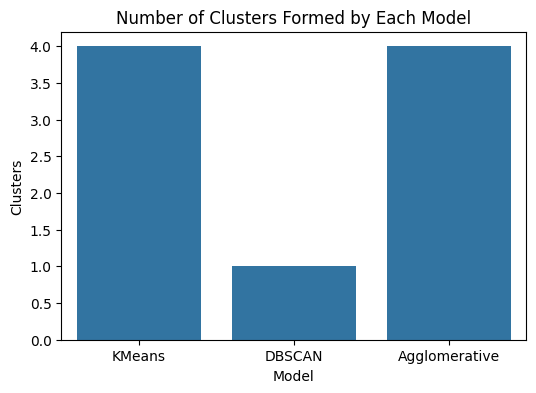

In [36]:
cluster_counts = [results[name]["clusters"] for name in model_names]

plt.figure(figsize=(6,4))
sns.barplot(x=model_names, y=cluster_counts)
plt.title("Number of Clusters Formed by Each Model")
plt.ylabel("Clusters")
plt.xlabel("Model")
plt.show()

This chart is a presentation of how many clusters each model is creating. DBScan is only producing one cluster so not very useful. Both K-Means and Hierarchical models are creating 4 clusters.

Cluster Size Distribution by Models

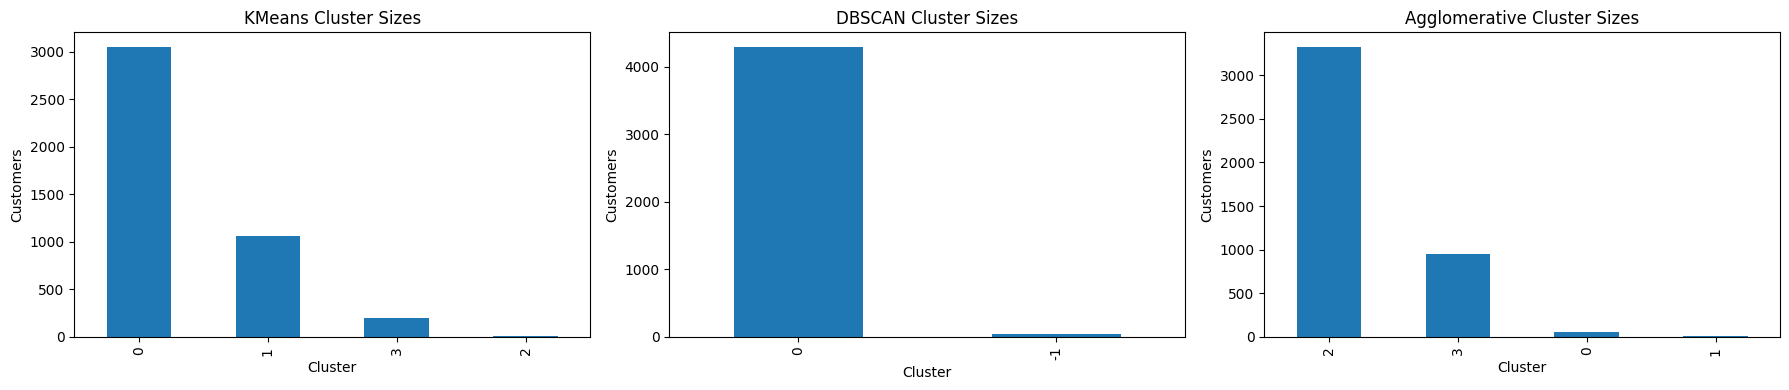

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18,4))

for ax, (name, res) in zip(axes, results.items()):
    labels = res["model"].fit_predict(X_rfm)
    pd.Series(labels).value_counts().plot(kind="bar", ax=ax)
    ax.set_title(f"{name} Cluster Sizes")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Customers")

plt.tight_layout()
plt.show()

In this plot we are mapping the number of customers per clusters. DBScan is placing all customers in one cluster so not very useful. K-Means and Hierarchical clustering models are making 4 clusters. That said K-Means is doing a better job of classifying customers across all 4 clusters while Hierarchial model is being more biased towards one cluster.

Best Model Selection

In [38]:
best_model_name = max(results, key=lambda x: results[x]["silhouette_score"])
best_pipeline = results[best_model_name]["model"]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"Silhouette Score: {results[best_model_name]['silhouette_score']:.4f}")



🏆 Best Model: KMeans
Silhouette Score: 0.6162


Final labelling of Clusters in RFM Table

In [39]:
rfm["Cluster"] = best_pipeline.fit_predict(X_rfm)

Interpreting Clusters using RFM average

In [40]:
cluster_summary = (
    rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]]
    .mean()
    .round(2)
)

cluster_summary

,Recency,Frequency,Monetary
Cluster,,,
0,43.70,3.68,1359.05
1,248.08,1.55,480.62
2,7.38,82.54,127338.31
3,15.50,22.33,12709.09


Mapping Clustering Labels

In [41]:
cluster_labels = {
    0: "High-Value",
    1: "Regular",
    2: "Occasional",
    3: "At-Risk"
}

rfm["Segment"] = rfm["Cluster"].map(cluster_labels)


Saving Best Model Pipeline

In [42]:
joblib.dump(best_pipeline, "best_rfm_clustering_pipeline.pkl")

['best_rfm_clustering_pipeline.pkl']

Product Recommendation

In [43]:
customer_product_matrix = df_data.pivot_table(
    index="CustomerID",
    columns="Description",
    values="Quantity",
    aggfunc="sum",
    fill_value=0
)

customer_product_matrix.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Compute Cosine Similarity between Items

In [44]:
product_similarity = cosine_similarity(customer_product_matrix.T)

In [45]:
products = customer_product_matrix.columns
top_n_store = 10

similar_products_dict = {}

for idx, product in enumerate(products):
    sim_scores = product_similarity[idx]

    top_indices = np.argsort(sim_scores)[::-1][1:top_n_store+1]

    similar_products_dict[product] = [
        (products[i], float(sim_scores[i])) for i in top_indices
    ]

similar_products_dict

{' 4 PURPLE FLOCK DINNER CANDLES': [('4 PINK DINNER CANDLE SILVER FLOCK',
   0.6624862210563687),
  ('PINK/FLOWER RABBIT EGG WARMER ', 0.40194307953952335),
  ('4 BLUE DINNER CANDLES SILVER FLOCK', 0.36479499424396694),
  ('GREEN WIRE STANDING CANDLE HOLDER', 0.34114029038125254),
  ('12 IVORY ROSE PEG PLACE SETTINGS', 0.3124665996827561),
  ('BAKING MOULD EASTER EGG WHITE CHOC', 0.30663289968487667),
  ('BLACK MINI TAPE MEASURE ', 0.30208244726680744),
  ('SET OF 6 KASHMIR FOLKART BAUBLES', 0.2966114665822693),
  ('METAL RABBIT LADDER EASTER ', 0.2952798009220152),
  ('CAMOUFLAGE EAR MUFF HEADPHONES', 0.2827896943769041)],
 " 50'S CHRISTMAS GIFT BAG LARGE": [(' RED SPOT GIFT BAG LARGE',
   0.9008488090965623),
  ('RED RETROSPOT MUG', 0.8989365995664139),
  ("50'S CHRISTMAS PAPER GIFT BAG", 0.8944451982725914),
  ('EGG CUP HENRIETTA HEN CREAM ', 0.8908237437491222),
  ('RED RETROSPOT SUGAR JAM BOWL', 0.8852238425620248),
  ('RED RETROSPOT SMALL MILK JUG', 0.8845574165323444),
  ('EGG C

Defining Recommender Function

In [46]:
def recommend_products(product_name, top_n=5):
    product_name = product_name.strip()

    if product_name not in similar_products_dict:
        return [f"Product '{product_name}' not found."]

    recommendations = similar_products_dict[product_name][:top_n]

    return [prod for prod, score in recommendations]

Testing Recommender Function

In [47]:
recommend_products("WHITE HANGING HEART T-LIGHT HOLDER")

['GIN + TONIC DIET METAL SIGN',
 'RED HANGING HEART T-LIGHT HOLDER',
 'WASHROOM METAL SIGN',
 'LAUNDRY 15C METAL SIGN',
 'GREEN VINTAGE SPOT BEAKER']

Saving Recommender

In [48]:
joblib.dump(similar_products_dict, "top_similar_products.pkl")

['top_similar_products.pkl']